Импортирование необходимых библиотек

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

Определение функции $f(x)$, подлежащей интегрированию
Здесь: $f(x) = 2^x$ на отрезке $[0, 1]$

In [11]:
def f(x):
    return 2**x

Генераторы разбиений отрезка

In [12]:
def uniform_partition(a, b, n):
    return np.linspace(a, b, n+1)

###Численные методы  интегрирования

Метод прямоугольников.  
method: 'left', 'right', 'mid', 'random' — выбор точки $\xi_i$  на каждом $Δ_i$

In [13]:
def rectangle_rule(x, method='mid'):
    a, b = x[0], x[-1]
    n = len(x) - 1
    s = 0.0
    for i in range(1, n+1):
        dx = x[i] - x[i-1]
        if method == 'left':
            xi = x[i-1]
        elif method == 'right':
            xi = x[i]
        elif method == 'mid':
            xi = 0.5 * (x[i-1] + x[i])
        elif method == 'random':
            xi = random.uniform(x[i-1], x[i])
        else:
            raise ValueError("Unknown method")
        s += f(xi) * dx
    return s

Метод трапеций:
$s_i = (f(x_{i-1}) + f(x_i)) · \frac{|Δ_i|}{2}$

In [14]:
def trapezoidal_rule(x):
    s = 0.0
    n = len(x) - 1
    for i in range(1, n+1):
        dx = x[i] - x[i-1]
        s += 0.5 * (f(x[i-1]) + f(x[i])) * dx
    return s

 Метод Симпсона. Требует чётного числа интервалов (n должен быть чётным).
Формула на каждом двухподинтервале:
$s = \Bigg(f(x_{i-1}) + 4f\Bigg(\frac{x_i + x_{i-1}}{2} \Bigg) + f(x_i)\Bigg)  \frac{|Δ_i|}{6}$

In [15]:
def simpson_rule(x):
    n = len(x) - 1
    if n % 2 != 0:
        raise ValueError("Simpson's rule requires an even number of intervals")
    s = 0.0
    for i in range(1, n+1):
        a, b = x[i-1], x[i]
        dx = b - a
        s += (f(a) + 4*f((a + b)/ 2) + f(b)) * dx / 6.0
    return s

##Визуализация матодов и подсчет метрик

Визуализация: построение закрашенных областей $s_i$ и графика $f(x)$

In [16]:
def plot_approximation(x, method_func, method_name, ax):
    a, b = x[0], x[-1]
    X = np.linspace(a, b, 400)
    ax.plot(X, f(X), 'k', label='f(x)')
    n = len(x) - 1
    for i in range(1, n+1):
        xs = [x[i-1], x[i-1], x[i], x[i]]
        if method_name.startswith('rect'):
            # use rectangle height at sample point
            if 'left' in method_name:
                xi = x[i-1]
            elif 'right' in method_name:
                xi = x[i]
            elif 'mid' in method_name:
                xi = 0.5 * (x[i-1] + x[i])
            else:
                xi = random.uniform(x[i-1], x[i])
            ys = [0, f(xi), f(xi), 0]
        elif method_name == 'trapezoid':
            ys = [0, f(x[i-1]), f(x[i]), 0]
        elif method_name == 'simpson':
            xi = 0.5*(x[i-1] + x[i])
            ys = [0, f(x[i-1]), f(x[i]), 0]
        ax.fill(xs, ys, alpha=0.3)
    ax.set_title(f"{method_name}, n={n}")
    ax.legend()

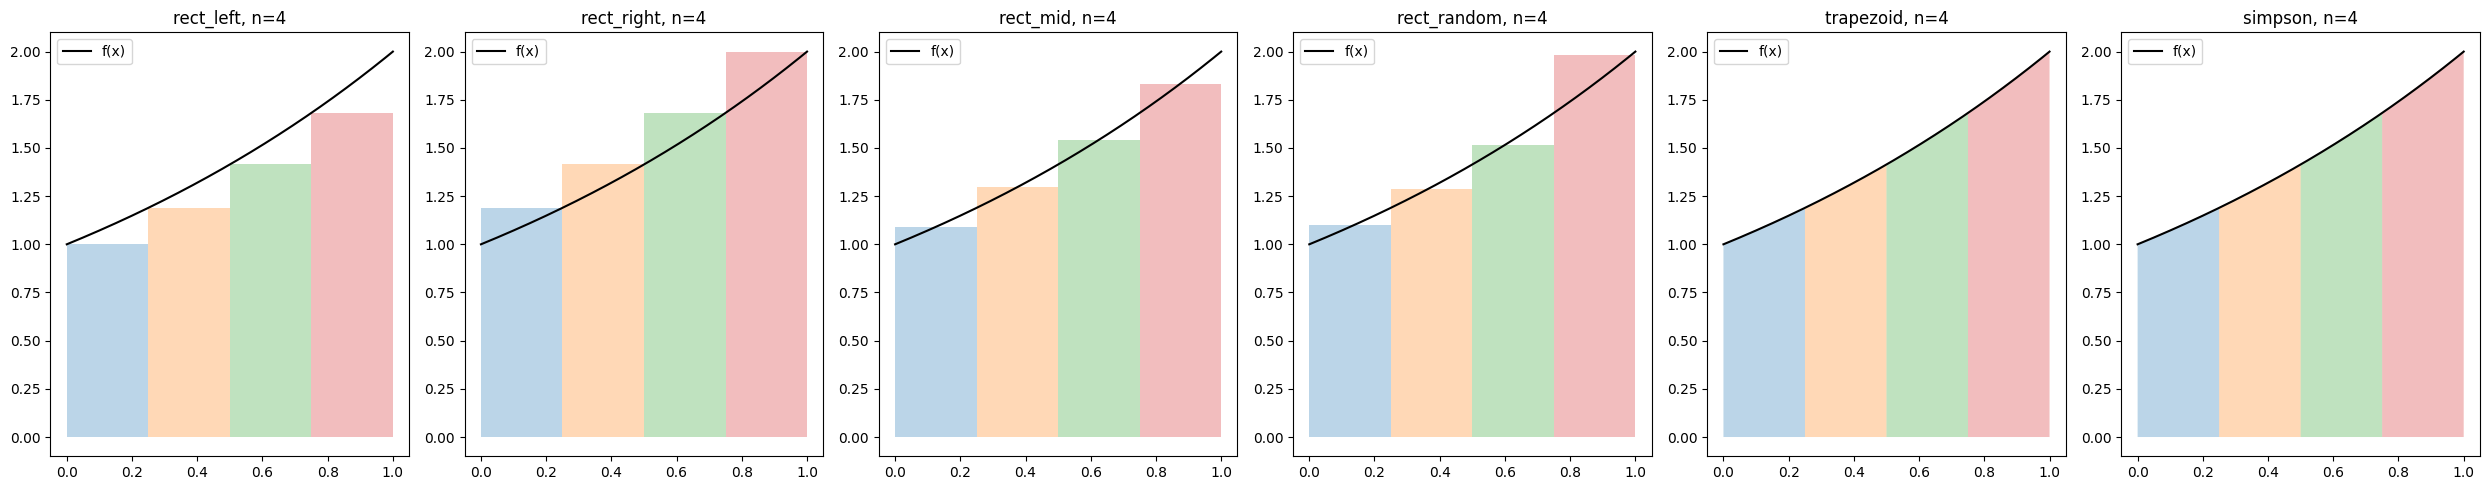

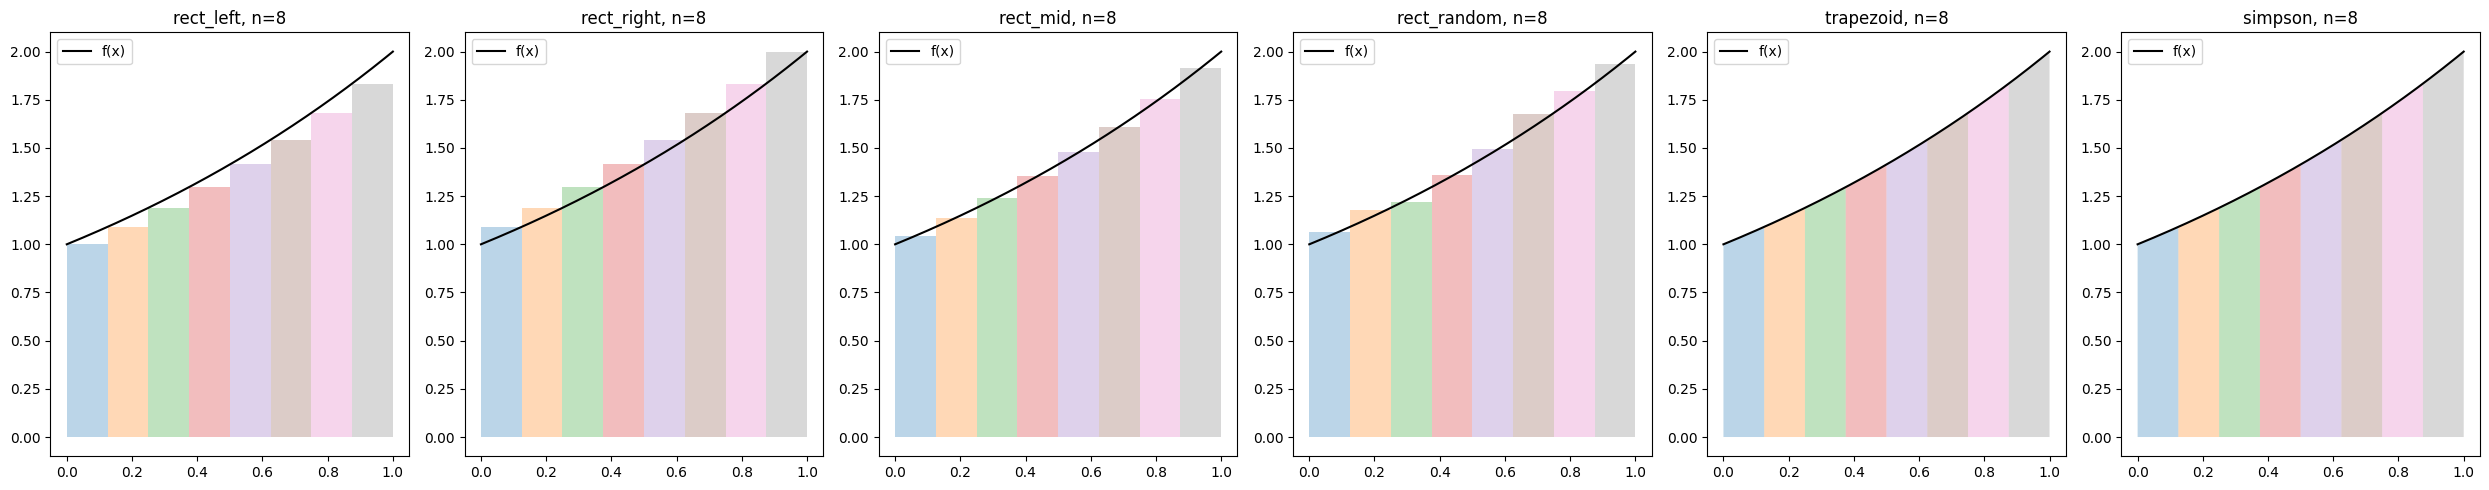

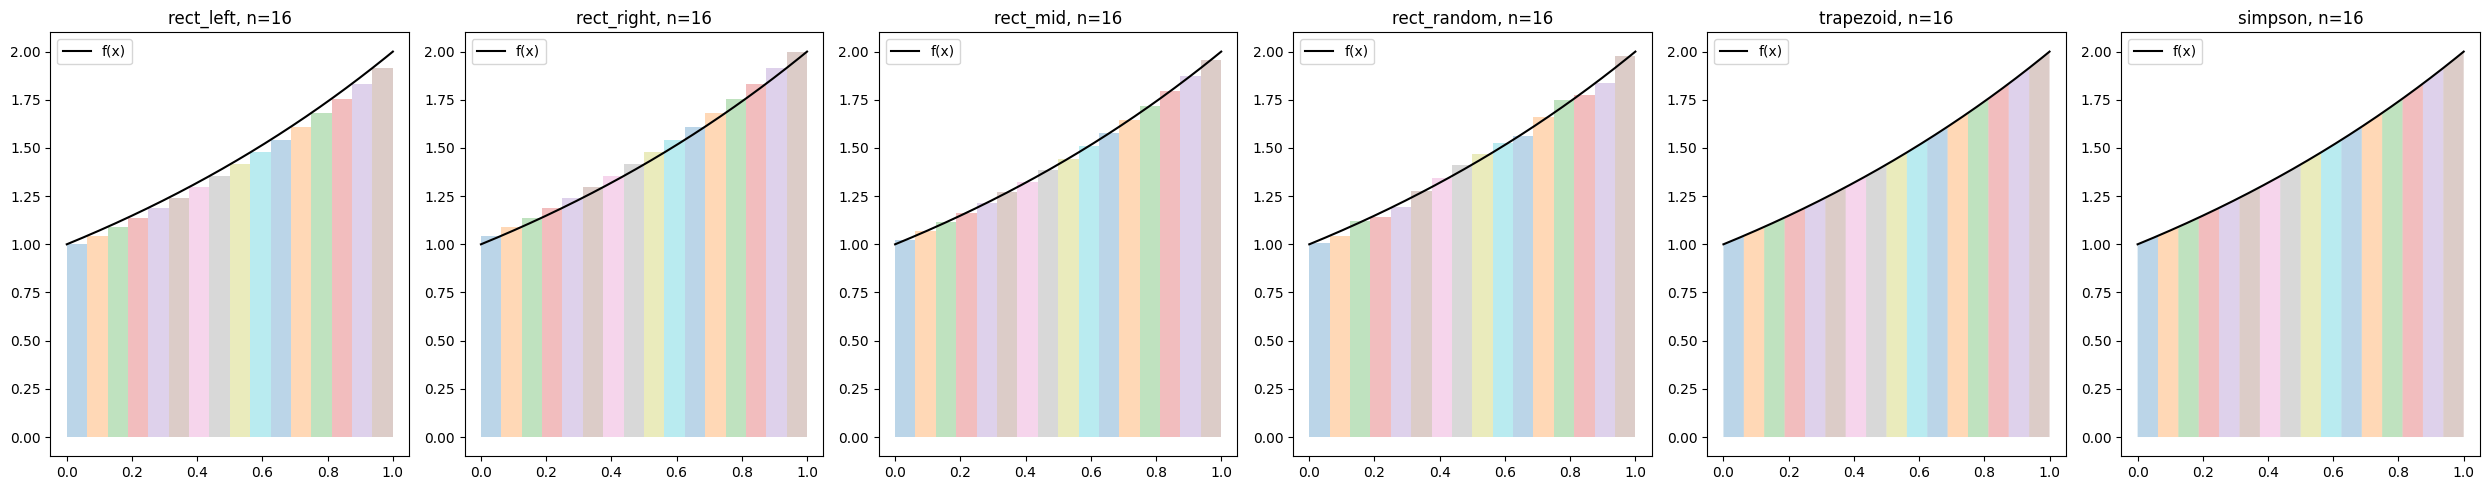

In [51]:
a, b = 0.0, 1.0
analytic = (2.0 - 1.0) / np.log(2.0)

methods = [ (lambda x: rectangle_rule(x, 'left'), 'rect_left'),
            (lambda x: rectangle_rule(x, 'right'), 'rect_right'),
            (lambda x: rectangle_rule(x, 'mid'), 'rect_mid'),
            (lambda x: rectangle_rule(x, 'random'), 'rect_random'),
            (trapezoidal_rule, 'trapezoid'),
            (simpson_rule, 'simpson')]
for n in [4, 8, 16]:
  x = uniform_partition(a, b, n)

  fig, axes = plt.subplots(1, 6, figsize=(25, 5))
  axes = axes.flatten()
  for ax, (func, name) in zip(axes, methods):
      plot_approximation(x, func, name, ax)
  plt.tight_layout()
  plt.show()

##Посчет метрик и их визуализация

In [46]:
method_names = ['rect_left', 'rect_right', 'rect_mid', 'rect_random', 'trapezoid', 'simpson']
n = [2**i for i in range(1, 8)]
df = pd.DataFrame(index=n, columns=method_names)
for n_val in n:
    x = uniform_partition(a, b, n_val)
    for func, name in methods:
        val = func(x)
        mae = abs(val - analytic)
        df.loc[n_val, name] = mae
df

,rect_left,rect_right,rect_mid,rect_random,trapezoid,simpson
2,0.235588,0.264412,0.007195,0.12445,0.014412,0.000007
4,0.121392,0.128608,0.001803,0.00281,0.003608,0.0
8,0.061598,0.063402,0.000451,0.026032,0.000902,0.0
16,0.031024,0.031476,0.000113,0.001386,0.000226,0.0
32,0.015569,0.015681,0.000028,0.003444,0.000056,0.0
64,0.007798,0.007827,0.000007,0.000689,0.000014,0.0
128,0.003903,0.00391,0.000002,0.000068,0.000004,0.0


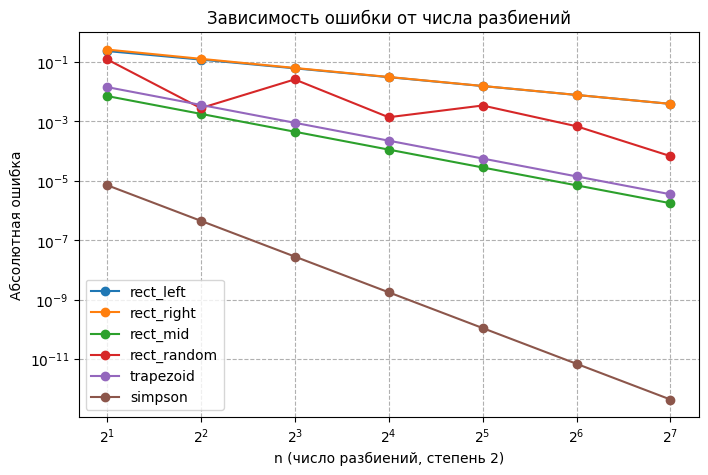

In [49]:
plt.figure(figsize=(8, 5))
for name in method_names:
    plt.plot(df.index, df[name], marker='o', label=name)
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('n (число разбиений, степень 2)')
plt.ylabel('Абсолютная ошибка')
plt.title('Зависимость ошибки от числа разбиений')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()